# Objective
Find an **Insights** and create model for **sentiment analytics**

# 1. Preparation
## 1.1 Import Libraries

In [2]:
!pip install nltk

In [3]:
!pip install Sastrawi

In [4]:
!pip install wordcloud

In [5]:
!pip install keras

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

import re
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('word_tokenize')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, GRU, LSTM, Dense, Bidirectional, Dropout, SpatialDropout1D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')
pd.pandas.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Error loading word_tokenize: Package 'word_tokenize' not
[nltk_data]     found in index


## 1.2 Load Datasets

In [2]:
df = pd.read_csv('venation_file_case2.csv')
df.head()

,review,rating,sentiment,source,category
0,"Warna:ok\nTekstur:buruk\nPigmentasi:Ok\n\nseller kirim foto, semua yg aku beli dibuka kecuali blush on, barang sampe di aku lepas blush onnya, aku mnt refund karena blush on yg aku beli 175 ribu, seller mau refund cm 35 ribu kan keterlaluan bgt ya. Tp aku minta balik 75 rb, janjinya 3-7 hari ak udh kyk ngemis, baru direfund hr ke 8 :)",1.0,negative,owned_shopee,shopee_blushon
1,"Baguss si barangnya realpict, tapi sayang penjualnya kurang teliti bgt pas peckingnya. Pesen hitam dikirim abu tua, sedikit kecewa",2.0,negative,owned_shopee,shopee_ikat_pinggang
2,Barang yg dikirim kurang 1 piece.. Jd jgn pesan byk2 di tempat ini.. 👎,NaN,negative,owned_tokped,tokped_speaker_bluetooth_negative
3,toko ga jelas yg di pesen charger yg dateng hansfree,1.0,negative,owned_shopee,shopee_charger
4,Tidak berfungsi sama sekali,1.0,negative,owned_shopee,shopee_kamera


In [8]:
print(f'There are {df.shape[0]} records with {df.shape[1]} features')

There are 3000 records with 5 features


## 1.3 Dataset Information

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   review     3000 non-null   object 
 1   rating     2403 non-null   float64
 2   sentiment  3000 non-null   object 
 3   source     3000 non-null   object 
 4   category   3000 non-null   object 
dtypes: float64(1), object(4)
memory usage: 117.3+ KB


In [10]:
disc_feat_df = [feature for feature in df.columns if df[feature].dtypes == 'int64']
cont_feat_df = [feature for feature in df.columns if df[feature].dtypes == 'float']
cat_feat_df = [feature for feature in df.columns if df[feature].dtypes == 'O']

In [11]:
print(f'Shape Data: {df.shape[0]} rows & {df.shape[1]} features')
print(f'Number of discrete features = {len(disc_feat_df)}')
print(f'Number of continous features = {len(cont_feat_df)}')
print(f'Number of categorical features = {len(cat_feat_df)}')

Shape Data: 3000 rows & 5 features
Number of discrete features = 0
Number of continous features = 1
Number of categorical features = 4


In [12]:
df.select_dtypes(object).describe().T

,count,unique,top,freq
review,3000,2980,Bagus,5
sentiment,3000,2,positive,1500
source,3000,2,owned_shopee,2403
category,3000,33,shopee_blushon,335


- As you can see, **source** features only have 1 unique which make it's value are same for every records then it means it's useless features
- Also category features will not help much for this usecase since we only want to extract review information

In [3]:
drop_feat = df.drop(columns=['source', 'category'])
drop_feat.head()

,review,rating,sentiment
0,"Warna:ok\nTekstur:buruk\nPigmentasi:Ok\n\nseller kirim foto, semua yg aku beli dibuka kecuali blush on, barang sampe di aku lepas blush onnya, aku mnt refund karena blush on yg aku beli 175 ribu, seller mau refund cm 35 ribu kan keterlaluan bgt ya. Tp aku minta balik 75 rb, janjinya 3-7 hari ak udh kyk ngemis, baru direfund hr ke 8 :)",1.0,negative
1,"Baguss si barangnya realpict, tapi sayang penjualnya kurang teliti bgt pas peckingnya. Pesen hitam dikirim abu tua, sedikit kecewa",2.0,negative
2,Barang yg dikirim kurang 1 piece.. Jd jgn pesan byk2 di tempat ini.. 👎,NaN,negative
3,toko ga jelas yg di pesen charger yg dateng hansfree,1.0,negative
4,Tidak berfungsi sama sekali,1.0,negative


## 1.4 Null Values

In [7]:
df_null = pd.DataFrame(data = [drop_feat.isna().sum(), round(drop_feat.isna().sum()/df.shape[0]*100, 2)], 
                       index=['Count', 'Percentage']).T.style.background_gradient(cmap='Blues')
df_null

,Count,Percentage
review,0.000000,0.000000
rating,597.000000,19.900000
sentiment,0.000000,0.000000


- We have **597** missing data, and since it only 1 column I will turn all missing value into data test
- And delete all missing values (since it will be used for data test) in data train

In [15]:
df_test = drop_feat[drop_feat['rating'].isnull()]
print(f'And now I have {df_test.shape[0]} records for data test with same features as data train')

And now I have 597 records for data test with same features as data train


In [16]:
df_null = drop_feat.dropna()
print(f"Now there are {df_null['rating'].isna().sum()} missing values on rating features")

Now there are 0 missing values on rating features


## 1.5 Duplicate Values

In [17]:
print(f'There are {df_null.duplicated().sum()} duplicate values for train data')
print(f'There are {df_test.duplicated().sum()} duplicate values for test data')

There are 20 duplicate values for train data
There are 0 duplicate values for test data


In [18]:
#Duplicated data in data_train
df_null[df_null.duplicated()].sort_values(by='review')

,review,rating,sentiment
2597,Kualitas produk sangat baik Harga produk sangat baik Kecepatan pengiriman sangat baik,5.0,positive
1964,Kualitas produk sangat baik Harga produk sangat baik Kecepatan pengiriman sangat baik Respon penjual sangat baik,5.0,positive
2566,Kualitas produk sangat baik Harga produk sangat baik Kecepatan pengiriman sangat baik Respon penjual sangat baik,5.0,positive
2509,Kualitas produk sangat baik Harga produk sangat baik Kecepatan pengiriman sangat baik Respon penjual sangat baik,5.0,positive
2844,Kualitas produk sangat baik Harga produk sangat baik Kecepatan pengiriman sangat baik Respon penjual sangat baik Respon penjual sangat baik,5.0,positive
2925,Kualitas produk sangat baik. Produk original.,5.0,positive
2528,Kualitas produk sangat baik. Produk original. Harga produk sangat baik. Kecepatan pengiriman sangat baik. Respon penjual sangat baik.,5.0,positive
2626,Kualitas produk sangat baik. Produk original. Harga produk sangat baik. Kecepatan pengiriman sangat baik. Respon penjual sangat baik.,5.0,positive
2835,Alhamdulillah yg ditunggu² sudah datang..\nPengiriman lumayan cepet..\nPacking rapi..\nCocok dehh..\nHarga juga miring bangettt ..\nMantull?????,5.0,positive
1665,Bagus,5.0,positive


In [19]:
df_clean = df_null.drop_duplicates()
print(f'Now there are {df_clean.duplicated().sum()} duplicate data on data train')
print(f'And {df_clean.duplicated().sum()} duplicate data on data test')

Now there are 0 duplicate data on data train
And 0 duplicate data on data test


In [20]:
df_test

,review,rating,sentiment
2,Barang yg dikirim kurang 1 piece.. Jd jgn pesan byk2 di tempat ini.. 👎,NaN,negative
8,kurang ok flasdisk ya.. pengiriman cepat,NaN,negative
9,pesan masker yang dewasa datang yang anak anak,NaN,negative
10,g mau tau alamat pengiriman dmna asal kirim aja..,NaN,negative
11,"kecewa Boss,,, beli 2pcs semua rusak,,, hadeeeww,,,",NaN,negative
...,...,...,...
1487,"BELI 2 satu kupongan sudah pecah sampai ke tempat saya,",NaN,negative
1488,Order headloop malah ngirim earloop,NaN,negative
1492,"plesdis rusak dijual,kayak eek yg jual,******...",NaN,negative
1493,Gabisa menyimpan data setelah flashdisk dicabut dari komputer..,NaN,negative


# 2. Data pre-processing
## 2.1 Feature Engineering

Since we already have the score for every review we don't need to find **polarity scoring**, 

Let see how the distribution of sentiment and rating data

In [21]:
df_clean.groupby(['sentiment', 'rating'])[['review']].count()

review
sentiment rating        
negative  1.0        592
          2.0        311
positive  4.0        127
          5.0       1353

But I'll make the sentiment into 3 instead of 2, for the 3rd sentiment the rating will be between 1.0 and 5.0

In [22]:
df_viz = df_clean.copy()
df_viz['sentiment'] = np.where(df_viz['rating'] == 2.0, df_viz['sentiment'].replace('negative', 'neutral'),df_viz['sentiment'])
df_viz['sentiment'] = np.where(df_viz['rating'] == 4.0, df_viz['sentiment'].replace('positive', 'neutral'),df_viz['sentiment'])

In [23]:
#Replace rating
df_viz['rating'] = df_viz['rating'].replace(2.0, 2)
df_viz['rating'] = df_viz['rating'].replace(4.0, 2)
df_viz['rating'] = df_viz['rating'].replace(5.0, 3)

In [24]:
df_viz['rating'].value_counts()

3.0    1353
1.0     592
2.0     438
Name: rating, dtype: int64

In [25]:
df_clean['sentiment'].value_counts()

positive    1480
negative     903
Name: sentiment, dtype: int64

In [26]:
df_viz['sentiment'].value_counts()

positive    1353
negative     592
neutral      438
Name: sentiment, dtype: int64

## 2.2 Additional Features 

In [27]:
#Count number of words
df_viz['word_count'] = df_viz['review'].apply(lambda x: len(x.split()))

#Count number unique of words
df_viz['unique_word_count'] = df_viz['review'].apply(lambda x: len(set(x.split())))

#Count stop words
def count_stopwords(text):
    stop_words = set(stopwords.words('indonesian'))  
    word_tokens = word_tokenize(text)
    stopwords_x = [w for w in word_tokens if w in stop_words]
    return len(stopwords_x)
df_viz['stopword_count'] = df_viz['review'].apply(lambda x: count_stopwords(x))

df_viz.head()

,review,rating,sentiment,word_count,unique_word_count,stopword_count
0,"Warna:ok\nTekstur:buruk\nPigmentasi:Ok\n\nseller kirim foto, semua yg aku beli dibuka kecuali blush on, barang sampe di aku lepas blush onnya, aku mnt refund karena blush on yg aku beli 175 ribu, seller mau refund cm 35 ribu kan keterlaluan bgt ya. Tp aku minta balik 75 rb, janjinya 3-7 hari ak udh kyk ngemis, baru direfund hr ke 8 :)",1.0,negative,61,51,16
1,"Baguss si barangnya realpict, tapi sayang penjualnya kurang teliti bgt pas peckingnya. Pesen hitam dikirim abu tua, sedikit kecewa",2.0,neutral,19,19,3
3,toko ga jelas yg di pesen charger yg dateng hansfree,1.0,negative,10,9,2
4,Tidak berfungsi sama sekali,1.0,negative,4,4,2
5,"Gak pas , jadi gk kepasang , gk bisa nempel gara-gara gk pas",1.0,negative,13,9,2


## 2.3 Pre-process Text

In [28]:
def cleaning(text):
    text = text.lower()
    text = re.sub('\s+', ' ', text) #remove double spacing
    text = re.sub('([0-9]+)', '', text) # remove numbers
    text = text.replace('\n', ' ') # replace new line into space
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) # strip punctuation
    text = text.strip(' ') # remove characters space from both left and right text
    return text
    
def tokenizing(text): #Splitting a string, text into a list of token
    text = word_tokenize(text)
    return text
    
def filtering_stopwords(text): #Remove stopwords from text
    stop_words = set(stopwords.words('indonesian'))
    filtered = []
    for txt in text:
        if txt not in stop_words:
            filtered.append(txt)
    text = filtered
    return text

    
def stemming_text(text): #Reducing word to it's original words or roots of words
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    text = [stemmer.stem(word) for word in text]
    return text

def to_sentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

I extract all of stopwards from original source of sastrawi github (https://github.com/har07/PySastrawi/blob/0ab8ce2a994679af63880f3bdd1bb23570ffc010/src/Sastrawi/StopWordRemover/StopWordRemoverFactory.py), since **StopWordRemoverFactory().get_stop_words()** not provided all of stopwords

In [29]:
manual_stopwords = ['a','ada','adalah','adanya','adapun','agak','agaknya','agar','akan','akankah','akhir',
            'akhiri','akhirnya','aku','akulah','amat','amatlah','anda','andalah','antar','antara',
            'antaranya','apa','apaan','apabila','apakah','apalagi','apatah','arti','artinya','asal',
            'asalkan','atas','atau','ataukah','ataupun','awal','awalnya','b','bagai','bagaikan',
            'bagaimana','bagaimanakah','bagaimanapun','bagainamakah','bagi','bagian','bahkan','bahwa',
            'bahwasannya','bahwasanya','baik','baiklah','bakal','bakalan','balik','banyak','bapak',
            'baru','bawah','beberapa','begini','beginian','beginikah','beginilah','begitu','begitukah',
            'begitulah','begitupun','bekerja','belakang','belakangan','belum','belumlah','benar',
            'benarkah','benarlah','berada','berakhir','berakhirlah','berakhirnya','berapa','berapakah',
            'berapalah','berapapun','berarti','berawal','berbagai','berdatangan','beri','berikan',
            'berikut','berikutnya','berjumlah','berkali-kali','berkata','berkehendak','berkeinginan',
            'berkenaan','berlainan','berlalu','berlangsung','berlebihan','bermacam','bermacam-macam',
            'bermaksud','bermula','bersama','bersama-sama','bersiap','bersiap-siap','bertanya',
            'bertanya-tanya','berturut','berturut-turut','bertutur','berujar','berupa','besar',
            'betul','betulkah','biasa','biasanya','bila','bilakah','bisa','bisakah','boleh','bolehkah',
            'bolehlah','buat','bukan','bukankah','bukanlah','bukannya','bulan','bung','c','cara',
            'caranya','cukup','cukupkah','cukuplah','cuma','d','dahulu','dalam','dan','dapat','dari',
            'daripada','datang','dekat','demi','demikian','demikianlah','dengan','depan','di','dia',
            'diakhiri','diakhirinya','dialah','diantara','diantaranya','diberi','diberikan','diberikannya',
            'dibuat','dibuatnya','didapat','didatangkan','digunakan','diibaratkan','diibaratkannya',
            'diingat','diingatkan','diinginkan','dijawab','dijelaskan','dijelaskannya','dikarenakan',
            'dikatakan','dikatakannya','dikerjakan','diketahui','diketahuinya','dikira','dilakukan',
            'dilalui','dilihat','dimaksud','dimaksudkan','dimaksudkannya','dimaksudnya','diminta',
            'dimintai','dimisalkan','dimulai','dimulailah','dimulainya','dimungkinkan','dini','dipastikan',
            'diperbuat','diperbuatnya','dipergunakan','diperkirakan','diperlihatkan','diperlukan',
            'diperlukannya','dipersoalkan','dipertanyakan','dipunyai','diri','dirinya','disampaikan',
            'disebut','disebutkan','disebutkannya','disini','disinilah','ditambahkan','ditandaskan',
            'ditanya','ditanyai','ditanyakan','ditegaskan','ditujukan','ditunjuk','ditunjuki','ditunjukkan',
            'ditunjukkannya','ditunjuknya','dituturkan','dituturkannya','diucapkan','diucapkannya',
            'diungkapkan','dong','dua','dulu','e','empat','enak','enggak','enggaknya','entah','entahlah',
            'f','g','guna','gunakan','h','hadap','hai','hal','halo','hallo','hampir','hanya','hanyalah',
            'hari','harus','haruslah','harusnya','helo','hello','hendak','hendaklah','hendaknya','hingga',
            'i','ia','ialah','ibarat','ibaratkan','ibaratnya','ibu','ikut','ingat','ingat-ingat','ingin',
            'inginkah','inginkan','ini','inikah','inilah','itu','itukah','itulah','j','jadi','jadilah',
            'jadinya','jangan','jangankan','janganlah','jauh','jawab','jawaban','jawabnya','jelas',
            'jelaskan','jelaslah','jelasnya','jika','jikalau','juga','jumlah','jumlahnya','justru',
            'k','kadar','kala','kalau','kalaulah','kalaupun','kali','kalian','kami','kamilah','kamu',
            'kamulah','kan','kapan','kapankah','kapanpun','karena','karenanya','kasus','kata','katakan',
            'katakanlah','katanya','ke','keadaan','kebetulan','kecil','kedua','keduanya','keinginan',
            'kelamaan','kelihatan','kelihatannya','kelima','keluar','kembali','kemudian','kemungkinan',
            'kemungkinannya','kena','kenapa','kepada','kepadanya','kerja','kesampaian','keseluruhan',
            'keseluruhannya','keterlaluan','ketika','khusus','khususnya','kini','kinilah','kira',
            'kira-kira','kiranya','kita','kitalah','kok','kurang','l','lagi','lagian','lah','lain',
            'lainnya','laku','lalu','lama','lamanya','langsung','lanjut','lanjutnya','lebih','lewat',
            'lihat','lima','luar','m','macam','maka','makanya','makin','maksud','malah','malahan',
            'mampu','mampukah','mana','manakala','manalagi','masa','masalah','masalahnya','masih',
            'masihkah','masing','masing-masing','masuk','mata','mau','maupun','melainkan','melakukan',
            'melalui','melihat','melihatnya','memang','memastikan','memberi','memberikan','membuat',
            'memerlukan','memihak','meminta','memintakan','memisalkan','memperbuat','mempergunakan',
            'memperkirakan','memperlihatkan','mempersiapkan','mempersoalkan','mempertanyakan','mempunyai',
            'memulai','memungkinkan','menaiki','menambahkan','menandaskan','menanti','menanti-nanti',
            'menantikan','menanya','menanyai','menanyakan','mendapat','mendapatkan','mendatang','mendatangi',
            'mendatangkan','menegaskan','mengakhiri','mengapa','mengatakan','mengatakannya','mengenai',
            'mengerjakan','mengetahui','menggunakan','menghendaki','mengibaratkan','mengibaratkannya',
            'mengingat','mengingatkan','menginginkan','mengira','mengucapkan','mengucapkannya','mengungkapkan',
            'menjadi','menjawab','menjelaskan','menuju','menunjuk','menunjuki','menunjukkan','menunjuknya',
            'menurut','menuturkan','menyampaikan','menyangkut','menyatakan','menyebutkan','menyeluruh',
            'menyiapkan','merasa','mereka','merekalah','merupakan','meski','meskipun','meyakini','meyakinkan',
            'minta','mirip','misal','misalkan','misalnya','mohon','mula','mulai','mulailah','mulanya','mungkin',
            'mungkinkah','n','nah','naik','namun','nanti','nantinya','nya','nyaris','nyata','nyatanya',
            'o','oleh','olehnya','orang','p','pada','padahal','padanya','pak','paling','panjang','pantas',
            'para','pasti','pastilah','penting','pentingnya','per','percuma','perlu','perlukah','perlunya',
            'pernah','persoalan','pertama','pertama-tama','pertanyaan','pertanyakan','pihak','pihaknya',
            'pukul','pula','pun','punya','q','r','rasa','rasanya','rupa','rupanya','s','saat','saatnya','saja',
            'sajalah','salam','saling','sama','sama-sama','sambil','sampai','sampai-sampai','sampaikan','sana',
            'sangat','sangatlah','sangkut','satu','saya','sayalah','se','sebab','sebabnya','sebagai',
            'sebagaimana','sebagainya','sebagian','sebaik','sebaik-baiknya','sebaiknya','sebaliknya',
            'sebanyak','sebegini','sebegitu','sebelum','sebelumnya','sebenarnya','seberapa','sebesar',
            'sebetulnya','sebisanya','sebuah','sebut','sebutlah','sebutnya','secara','secukupnya','sedang',
            'sedangkan','sedemikian','sedikit','sedikitnya','seenaknya','segala','segalanya','segera',
            'seharusnya','sehingga','seingat','sejak','sejauh','sejenak','sejumlah','sekadar','sekadarnya',
            'sekali','sekali-kali','sekalian','sekaligus','sekalipun','sekarang','sekaranglah','sekecil',
            'seketika','sekiranya','sekitar','sekitarnya','sekurang-kurangnya','sekurangnya','sela','selain',
            'selaku','selalu','selama','selama-lamanya','selamanya','selanjutnya','seluruh','seluruhnya',
            'semacam','semakin','semampu','semampunya','semasa','semasih','semata','semata-mata','semaunya',
            'sementara','semisal','semisalnya','sempat','semua','semuanya','semula','sendiri','sendirian',
            'sendirinya','seolah','seolah-olah','seorang','sepanjang','sepantasnya','sepantasnyalah',
            'seperlunya','seperti','sepertinya','sepihak','sering','seringnya','serta','serupa','sesaat',
            'sesama','sesampai','sesegera','sesekali','seseorang','sesuatu','sesuatunya','sesudah',
            'sesudahnya','setelah','setempat','setengah','seterusnya','setiap','setiba','setibanya',
            'setidak-tidaknya','setidaknya','setinggi','seusai','sewaktu','siap','siapa','siapakah',
            'siapapun','sini','sinilah','soal','soalnya','suatu','sudah','sudahkah','sudahlah','supaya',
            't','tadi','tadinya','tahu','tak','tambah','tambahnya','tampak','tampaknya','tandas','tandasnya',
            'tanpa','tanya','tanyakan','tanyanya','tapi','tegas','tegasnya','telah','tempat','tentang','tentu',
            'tentulah','tentunya','tepat','terakhir','terasa','terbanyak','terdahulu','terdapat','terdiri',
            'terhadap','terhadapnya','teringat','teringat-ingat','terjadi','terjadilah','terjadinya','terkira',
            'terlalu','terlebih','terlihat','termasuk','ternyata','tersampaikan','tersebut','tersebutlah',
            'tertentu','tertuju','terus','terutama','tetap','tetapi','tiap','tiba','tiba-tiba','tiga','toh',
            'tuju','tunjuk','turut','tutur','tuturnya','u','ucap','ucapnya','ujar','ujarnya','umumnya','ungkap',
            'ungkapnya','untuk','usah','usai','v','w','waduh','wah','wahai','waktunya','walau','walaupun',
            'wong','x','y','ya','yaitu','yakin','yakni','yang', 'yg','z', 'tp', 'gara', 'si', 'ak']

In [30]:
def filtering_stopwords3(text):
    stop_factory = manual_stopwords
    filtered = []
    for txt in text:
        if txt not in stop_factory:
            filtered.append(txt)
    text = filtered
    return text

In [31]:
#Create new column contains clean and preprocessed text for data train and data test
df_viz['clean_text'] = df_viz['review'].apply(cleaning)
df_test['clean_text'] = df_test['review'].apply(cleaning)

#Drop review column since it's already replace by clean_text
df_viz = df_viz.drop(columns='review')
df_test = df_test.drop(columns='review')

#Create another column which will be the vocab of the corpus
df_viz['preprocessed_text'] = df_viz['clean_text'].apply(tokenizing)
df_viz['preprocessed_text'] = df_viz['preprocessed_text'].apply(filtering_stopwords3)
df_viz['preprocessed_text'] = df_viz['preprocessed_text'].apply(stemming_text)

In [32]:
df_viz.head()

,rating,sentiment,word_count,unique_word_count,stopword_count,clean_text,preprocessed_text
0,1.0,negative,61,51,16,warna ok tekstur buruk pigmentasi ok seller kirim foto semua yg aku beli dibuka kecuali blush on barang sampe di aku lepas blush onnya aku mnt refund karena blush on yg aku beli ribu seller mau refund cm ribu kan keterlaluan bgt ya tp aku minta balik rb janjinya hari ak udh kyk ngemis baru direfund hr ke,"[warna, ok, tekstur, buruk, pigmentasi, ok, seller, kirim, foto, beli, buka, kecuali, blush, on, barang, sampe, lepas, blush, onnya, mnt, refund, blush, on, beli, ribu, seller, refund, cm, ribu, bgt, rb, janji, udh, kyk, ngemis, direfund, hr]"
1,2.0,neutral,19,19,3,baguss si barangnya realpict tapi sayang penjualnya kurang teliti bgt pas peckingnya pesen hitam dikirim abu tua sedikit kecewa,"[baguss, barang, realpict, sayang, jual, teliti, bgt, pas, peckingnya, sen, hitam, kirim, abu, tua, kecewa]"
3,1.0,negative,10,9,2,toko ga jelas yg di pesen charger yg dateng hansfree,"[toko, ga, sen, charger, dateng, hansfree]"
4,1.0,negative,4,4,2,tidak berfungsi sama sekali,"[tidak, fungsi]"
5,1.0,negative,13,9,2,gak pas jadi gk kepasang gk bisa nempel gara gara gk pas,"[gak, pas, gk, pasang, gk, nempel, gk, pas]"


In [33]:
df_viz.tail()

,rating,sentiment,word_count,unique_word_count,stopword_count,clean_text,preprocessed_text
2995,3.0,positive,9,9,1,sukaa bangtt bagus bngtt aahh maacii pengirimannya juga cepett,"[sukaa, bangtt, bagus, bngtt, aahh, maacii, kirim, cepett]"
2996,3.0,positive,10,10,4,murah bangeet barangnya juga ori next bakal repurchase disini lagi,"[murah, bangeet, barang, ori, next, repurchase]"
2997,3.0,positive,6,6,1,barang sudah sampai semoga awet terimakasih,"[barang, moga, awet, terimakasih]"
2998,3.0,positive,7,7,2,belum coba nanti di edit penilaiannya yeyyyyyyy,"[coba, edit, nilai, yeyyyyyyy]"
2999,3.0,positive,24,21,5,alhamdulillah produk udh smpe maaf ga sesuai ftonya karena udh di kasih ke yg pesan udh dua kali beli disini ga mengecewakan kipas awet,"[alhamdulillah, produk, udh, smpe, maaf, ga, sesuai, ftonya, udh, kasih, pesan, udh, beli, ga, kecewa, kipas, awet]"


## 2.5 Tokenizing & Padding

In [34]:
df_final = df_viz.copy()

#Make text which have been preprocessed and filtered (tokenize) to untokenize (as a sentence)
max_feat = 100
X = df_final['clean_text']
tokenize = Tokenizer(num_words=max_feat, split= ' ')
tokenize.fit_on_texts(X.values)

- If I used X = df_final['preprocessed_text'].apply(to_sentence). It ends up with slightly better result but overvit
- If I used X = X = df_final['clean_text']. The result will not good as before but it isn't over or under fit (at sompe epochs point)

In [35]:
X = tokenize.texts_to_sequences(X.values)
X = pad_sequences(X)
X.shape

(2383, 50)

In [36]:
y = pd.get_dummies(df_final['sentiment']).values
y.shape

(2383, 3)

## 2.6 Split Train & Test data

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f'X_train have {X_train.shape[0]} rows & {X_train.shape[1]} features')
print(f'X_test have {X_test.shape[0]} rows & {X_test.shape[1]} features')

X_train have 1906 rows & 50 features
X_test have 477 rows & 50 features


# 3. Exploratory Data Analysis (EDA)

## 3.1 Target Distribution

In [38]:
def target_dist(data, var):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    df_final[var].value_counts().plot(kind="pie", explode=[0.06, 0.04, 0.04], colors=['#0F4C75', '#3282B8', '#BBE1FA'], autopct='%1.1f%%', ax=ax[0], shadow=True)
    ax[0].set_title(f"{var} Pie Chart")
    ax[0].set_ylabel('')

    count = sns.countplot(x=var, data=df_final, ax=ax[1], palette= ['#0F4C75', '#3282B8', '#BBE1FA'], order=df_final[var].value_counts().index)
    for bar in count.patches:
        count.annotate(format(bar.get_height()),
            (bar.get_x() + bar.get_width() / 2,
            bar.get_height()), ha='center', va='center',
            size=11, xytext=(0, 8),
            textcoords='offset points')
    ax[1].set_title(f"{var} Bar Chart")
    plt.show()

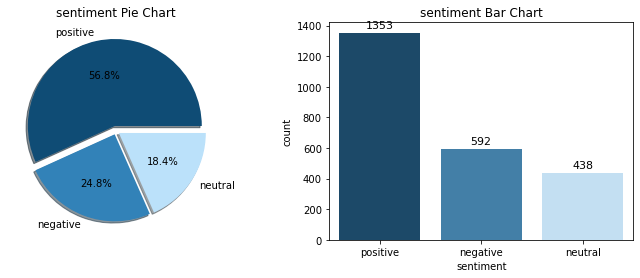

In [39]:
target_dist(df_final, 'sentiment')

- It shows that most of viewers give positive reviews about items or service they get
- Negative reviews has more records compare to people who give neutral reviews, it means maybe there are more people who get really bad products or maybe product which they get is not same as their order
- Let see what kind of negative reviews we have

In [40]:
df_final[df_final['sentiment'] == 'negative'].sample(5)

,rating,sentiment,word_count,unique_word_count,stopword_count,clean_text,preprocessed_text
958,1.0,negative,25,25,3,baru order masak di kirim barang yg sudah hampir kadaluarsa gak amanah bangat gabakal order disini lagi mengecewakan lain kali cek dulu sebelum ngirim barang,"[order, masak, kirim, barang, kadaluarsa, gak, amanah, bangat, gabakal, order, kecewa, cek, ngirim, barang]"
1164,1.0,negative,17,13,0,jgn beli dsni g amanah pesan doraemon helokity yg dkrim duanya helokity trus yg rusak,"[jgn, beli, dsni, amanah, pesan, doraemon, helokity, dkrim, dua, helokity, trus, rusak]"
1274,1.0,negative,19,17,4,kenyamanan aplikator beli di kirim satu matane picek barang gak sepiro di delok lek onok orderan ojok asal kirim,"[nyaman, aplikator, beli, kirim, matane, picek, barang, gak, sepiro, dok, lek, onok, order, ojok, kirim]"
1089,1.0,negative,10,8,1,saya pesan nya warna hitam kok dikirim nya warna merah,"[pesan, warna, hitam, kirim, warna, merah]"
828,1.0,negative,14,14,7,ujungnya kenapa seperti itu bambang untuk harga segitu okelah tapi jangan cacat juga lah,"[ujung, bambang, harga, segitu, oke, cacat]"


From 5 sample data above we can say that most of negative reviews either the products are really bad, not functioning properly, not telling the truth about the products condition, or the seller not responding the complaining of the customers

## 3.2 Word vs Unique word count 

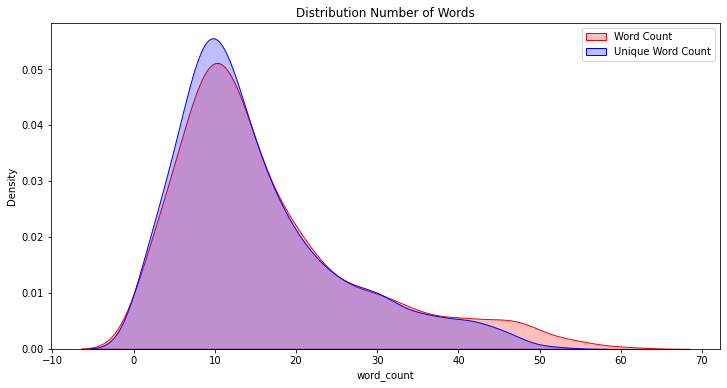

In [41]:
plt.figure(figsize=(12, 6))
sns.kdeplot(df_final['word_count'], shade=True, color='r')
sns.kdeplot(df_final['unique_word_count'], shade=True, color='b')
plt.legend(labels=["Word Count","Unique Word Count"])
plt.title("Distribution Number of Words")
plt.show()

- It shows that word and unique words almost have same amount of word used and also almost have same distribution
- Distribution for Word Count in review have almost 70 words and most of the reviews use between 8-12 words
- Same like word count, Unique Word count most of users use between 8-12 word to write the reviews

## 3.3 Words use for Positive, Negative, and Neutral reviews

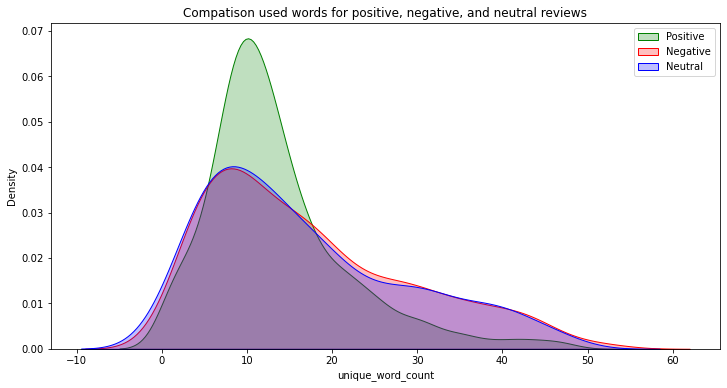

In [42]:
plt.figure(figsize=(12, 6))
sns.kdeplot(df_final[df_final['sentiment'] == 'positive']['unique_word_count'], shade=True, color='g')
sns.kdeplot(df_final[df_final['sentiment'] == 'negative']['unique_word_count'], shade=True, color='r')
sns.kdeplot(df_final[df_final['sentiment'] == 'neutral']['unique_word_count'], shade=True, color='b')
plt.legend(labels=["Positive","Negative", 'Neutral'])
plt.title("Compatison used words for positive, negative, and neutral reviews")
plt.show()

- It tells that people who give positive reviews most of them use less word to express they thought
- Compare to positive, neutral and negative use more words because they need to tell their dissapointment 

## 3.4 Most used words for Positive, Negative, Neutral reviews

In [43]:
def word_cloud(text, sentiment):
    
    list_words = ''
    for words in text[text['preprocessed_text'] == sentiment].clean_:
        for word in words:
            list_words += ' '+(word)

    most_word_used = WordCloud(width = 600, height = 400, 
                               background_color = 'white',
                               min_font_size = 10).generate(list_words)
    fig, ax = plt.subplots(figsize = (8, 6))
    ax.set_title('Word Cloud of Tweets Data', fontsize = 18)
    ax.grid(False)
    ax.imshow((most_word_used))
    fig.tight_layout(pad=0)
    ax.axis('off')
    plt.show()

In [44]:
for words in df_final[df_final['preprocessed_text'] == 'positive']['clean_text']:
    print(words)

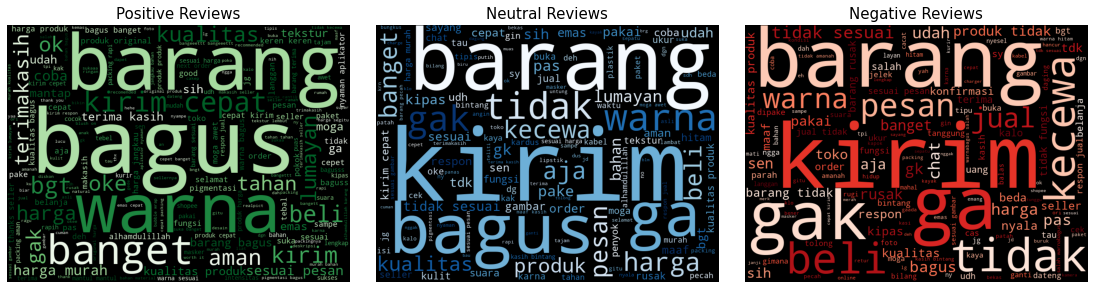

In [45]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))

list_word_positive = ''
for words in df_final[df_final['sentiment'] == 'positive'].preprocessed_text:
    for word in words:
        list_word_positive += ' '+(word)

# words = ' '.join([Text for Text in df_viz[df_viz['sentiment'] == 'positive']['preprocessed_text']])
word_cloud_pos = WordCloud(width = 800, height = 600, background_color = 'black', min_font_size = 10, colormap='Greens',
                           stopwords= manual_stopwords).generate(list_word_positive)
ax[0].set_title('Positive Reviews', fontsize = 15)
ax[0].grid(False)
ax[0].imshow((word_cloud_pos))
fig.tight_layout(pad=0)
ax[0].axis('off')

list_word_negative = ''
for words in df_final[df_final['sentiment'] == 'negative'].preprocessed_text:
    for word in words:
        list_word_negative += ' '+(word)

# words = ' '.join([Text for Text in df_viz[df_viz['sentiment'] == 'positive']['preprocessed_text']])
word_cloud_neg = WordCloud(width = 800, height = 600, background_color = 'black', min_font_size = 10, colormap='Reds',
                           stopwords= manual_stopwords).generate(list_word_negative)
ax[2].set_title('Negative Reviews', fontsize = 15)
ax[2].grid(False)
ax[2].imshow((word_cloud_neg))
fig.tight_layout(pad=0)
ax[2].axis('off')

list_word_neutral = ''
for words in df_final[df_final['sentiment'] == 'neutral'].preprocessed_text:
    for word in words:
        list_word_neutral += ' '+(word)

# words = ' '.join([Text for Text in df_viz[df_viz['sentiment'] == 'positive']['preprocessed_text']])
word_cloud_net = WordCloud(width = 800, height = 600, background_color = 'black', min_font_size = 10, colormap='Blues', 
                           stopwords= manual_stopwords).generate(list_word_neutral)
ax[1].set_title('Neutral Reviews', fontsize = 15)
ax[1].grid(False)
ax[1].imshow((word_cloud_net))
fig.tight_layout(pad=0)
ax[1].axis('off')

plt.show()

## 3.5 Most used words in reviews

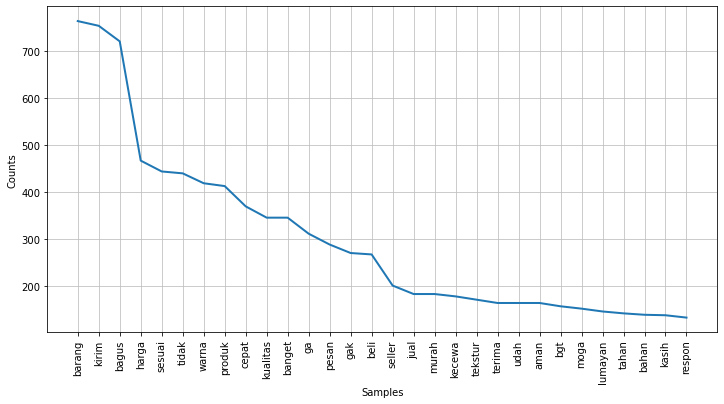

In [46]:
all_words = ''
for text in df_final['preprocessed_text']:
    for word in text:
        all_words += ' '+(word)
all_words = all_words.strip(' ')

plt.figure(figsize=(12,6))
token = tokenizing(all_words)
freq = nltk.FreqDist(token)
freq.plot(30, cumulative=False)
plt.show()


At least 5 top used words are a common meaning for a product so it doesn't goes to any specific sentiment, that's why they always showed up in every sentiment wordcloud

# 4. Define & Training Model
## 4.1 LSTM Model

In [47]:
lstm_model2 = Sequential()
lstm_model2.add(Embedding(input_dim = max_feat, output_dim = 64, input_length= X_train.shape[1]))
lstm_model2.add(LSTM(32, activation= 'tanh'))
lstm_model2.add(Dropout(0.2))
lstm_model2.add(Dense(16, activation= 'relu'))
lstm_model2.add(Dropout(0.2))
lstm_model2.add(Dense(units = 3, activation= 'softmax'))

lstm_model2.compile(loss = 'categorical_crossentropy', optimizer =  RMSprop(learning_rate=0.001), 
              metrics= ['accuracy'])
print(lstm_model2.summary())

my_callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, min_delta=0.0001),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, 
                                                 patience=5, min_lr=0.001)]

history1 = lstm_model2.fit(X_train, y_train, epochs=50, batch_size= 128, validation_data=(X_test, y_test), 
                           verbose= 2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 64)            6400      
                                                                 
 lstm (LSTM)                 (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 51        
                                                                 
Total params: 19,395
Trainable params: 19,395
Non-traina

In [48]:
lstm_model3 = Sequential()
lstm_model3.add(Embedding(input_dim = max_feat, output_dim = 64, input_length= X_train.shape[1]))
lstm_model3.add(Bidirectional(LSTM(32, activation= 'tanh')))
lstm_model3.add(Dropout(0.2))
lstm_model3.add(Dense(16, activation= 'relu'))
lstm_model3.add(Dropout(0.2))
lstm_model3.add(Dense(units = 3, activation= 'softmax'))

lstm_model3.compile(loss = 'categorical_crossentropy', optimizer =  RMSprop(learning_rate=0.001), 
              metrics= ['accuracy'])
print(lstm_model3.summary())

my_callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, min_delta=0.0001),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, 
                                                 patience=5, min_lr=0.001)]

history2 = lstm_model3.fit(X_train, y_train, epochs=50, batch_size= 128, validation_data=(X_test, y_test), 
                           verbose= 2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 64)            6400      
                                                                 
 bidirectional (Bidirectiona  (None, 64)               24832     
 l)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 51        
                                                      

## 4.2 GRU Model

In [49]:
gru_model1 = Sequential()
gru_model1.add(Embedding(input_dim = max_feat, output_dim = 32, input_length= X_train.shape[1]))
gru_model1.add(GRU(16, activation= 'tanh'))
gru_model1.add(Dropout(0.2))
gru_model1.add(Dense(units = 3, activation= 'softmax'))
lstm_model2.add(Dropout(0.2))

gru_model1.compile(loss = 'categorical_crossentropy', optimizer =  RMSprop(learning_rate=0.001), 
              metrics= ['accuracy'])
print(gru_model1.summary())

my_callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, min_delta=0.0001),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, 
                                                 patience=5, min_lr=0.001)]

history3 = gru_model1.fit(X_train, y_train, epochs=50, batch_size= 128, validation_data=(X_test, y_test), 
                           verbose= 2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 32)            3200      
                                                                 
 gru (GRU)                   (None, 16)                2400      
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 3)                 51        
                                                                 
Total params: 5,651
Trainable params: 5,651
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
15/15 - 2s - loss: 1.0351 - accuracy: 0.5493 - val_loss: 0.9758 - val_accuracy: 0.5681 - 2s/epoch - 146ms/step
Epoch 2/50
15/15 - 0s - loss: 0.9461 - accuracy: 0.5677 -

In [50]:
gru_model2 = Sequential()
gru_model2.add(Embedding(input_dim = max_feat, output_dim = 32, input_length= X_train.shape[1]))
gru_model2.add(Bidirectional(GRU(16, activation= 'tanh')))
gru_model2.add(Dropout(0.2))
gru_model2.add(Dense(units = 3, activation= 'softmax'))
lstm_model2.add(Dropout(0.2))

gru_model2.compile(loss = 'categorical_crossentropy', optimizer =  RMSprop(learning_rate=0.001), 
              metrics= ['accuracy'])
print(gru_model2.summary())

my_callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, min_delta=0.0001),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, 
                                                 patience=5, min_lr=0.001)]

history4 = gru_model2.fit(X_train, y_train, epochs=50, batch_size= 128, validation_data=(X_test, y_test), 
                           verbose= 2)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 32)            3200      
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               4800      
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 3)                 99        
                                                                 
Total params: 8,099
Trainable params: 8,099
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
15/15 - 4s - loss: 1.0293 - accuracy: 0.5509 - val_loss: 0.9774 - val_accuracy: 0.5681 - 4s/epoch - 24

# 5. Evaluation
## 5.1 LSTM Model Evaluation

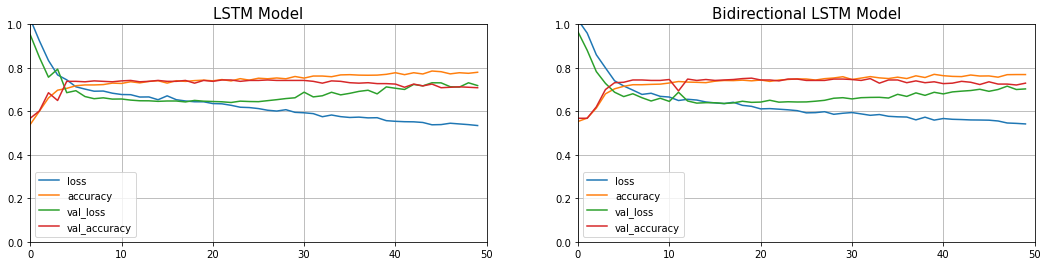

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

pd.DataFrame(history1.history).plot(ax = ax[0])
pd.DataFrame(history2.history).plot(ax = ax[1])

ax[0].grid(True)
ax[0].set_ylim(0, 1)
ax[0].set_xlim(0, 50)
ax[0].set_title('LSTM Model', fontsize = 15)
ax[1].grid(True)
ax[1].set_ylim(0, 1)
ax[1].set_xlim(0, 50)
ax[1].set_title('Bidirectional LSTM Model', fontsize = 15)
# fig.tight_layout(pad=0)

plt.show()

## 5.2 GRU Model Evaluation

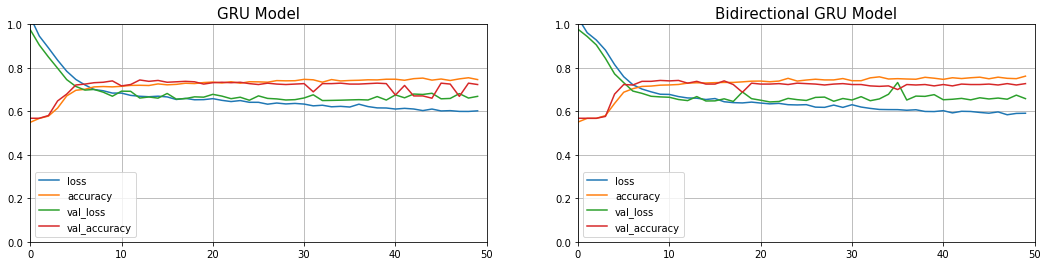

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

pd.DataFrame(history3.history).plot(ax = ax[0])
pd.DataFrame(history4.history).plot(ax = ax[1])

ax[0].grid(True)
ax[0].set_ylim(0, 1)
ax[0].set_xlim(0, 50)
ax[0].set_title('GRU Model', fontsize = 15)
ax[1].grid(True)
ax[1].set_ylim(0, 1)
ax[1].set_xlim(0, 50)
ax[1].set_title('Bidirectional GRU Model', fontsize = 15)
# fig.tight_layout(pad=0)

plt.show()

## 5.3 Sentiment result on Confussion Metrics

From 4 Model that I used, I'd choose Bidirectional LSTM since that's the only model which ends with least overfit

In [53]:
y_test=np.argmax(y_test, axis=1)

Model Accuracy on Test Data: 0.7274633123689728


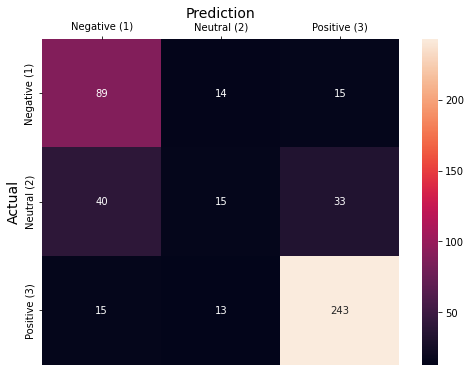

In [54]:
y_pred = gru_model2.predict(X_test)
y_pred=np.argmax(y_pred, axis=1)
confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print('Model Accuracy on Test Data:', acc)

fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(confusion_matrix(y_true = y_test, y_pred = y_pred), fmt = 'g', annot = True)
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('Prediction', fontsize = 14)
ax.set_xticklabels(['Negative (1)', 'Neutral (2)', 'Positive (3)'])
ax.set_ylabel('Actual', fontsize = 14)
ax.set_yticklabels(['Negative (1)', 'Neutral (2)', 'Positive (3)'])
plt.show()

# 6. Testing with new Data

In [55]:
# df_test = df_test.drop(columns='rating')
df_test.head()

,rating,sentiment,clean_text
2,NaN,negative,barang yg dikirim kurang piece jd jgn pesan byk di tempat ini 👎
8,NaN,negative,kurang ok flasdisk ya pengiriman cepat
9,NaN,negative,pesan masker yang dewasa datang yang anak anak
10,NaN,negative,g mau tau alamat pengiriman dmna asal kirim aja
11,NaN,negative,kecewa boss beli pcs semua rusak hadeeeww


In [56]:
#Perform preprocessed text for prediction

df_test['preprocessed_text'] = df_test['clean_text'].apply(tokenizing)
df_test['preprocessed_text'] = df_test['preprocessed_text'].apply(filtering_stopwords3)
df_test['preprocessed_text'] = df_test['preprocessed_text'].apply(stemming_text)
df_test.head()

,rating,sentiment,clean_text,preprocessed_text
2,NaN,negative,barang yg dikirim kurang piece jd jgn pesan byk di tempat ini 👎,"[barang, kirim, piece, jd, jgn, pesan, byk, ]"
8,NaN,negative,kurang ok flasdisk ya pengiriman cepat,"[ok, flasdisk, kirim, cepat]"
9,NaN,negative,pesan masker yang dewasa datang yang anak anak,"[pesan, masker, dewasa, anak, anak]"
10,NaN,negative,g mau tau alamat pengiriman dmna asal kirim aja,"[tau, alamat, kirim, dmna, kirim, aja]"
11,NaN,negative,kecewa boss beli pcs semua rusak hadeeeww,"[kecewa, boss, beli, pcs, rusak, hadeeeww]"


In [57]:
data_test = df_final.copy()
data_test['clean_text'] = df_final['preprocessed_text'].apply(to_sentence)
X_data = df_test['clean_text']
X_data = tokenize.texts_to_sequences(X_data.values)
X_data = pad_sequences(X_data)
X_data

array([[ 0,  0,  0, ..., 79,  2, 19],
       [ 0,  0,  0, ..., 32, 11, 16],
       [ 0,  0,  0, ..., 26, 53, 26],
       ...,
       [ 0,  0,  0, ...,  0, 85,  6],
       [ 0,  0,  0, ...,  0,  0, 87],
       [ 0,  0,  0, ..., 26,  9, 77]])

In [58]:
data_test = df_test['preprocessed_text'].apply(to_sentence)
data_test = tokenize.texts_to_sequences(data_test.values)
data_test = pad_sequences(data_test, maxlen = X.shape[1])
data_test

array([[ 0,  0,  0, ...,  3, 76, 79],
       [ 0,  0,  0, ..., 51, 76, 16],
       [ 0,  0,  0, ...,  0,  0, 79],
       ...,
       [ 0,  0,  0, ...,  0,  0, 85],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  9]])

In [59]:
y_pred_test = gru_model2.predict(data_test)
y_pred_test = np.argmax(y_pred_test, axis=1)
df_test['prediction'] = y_pred_test

#Mapping value of the prediction
df_test['prediction'] = df_test['prediction'].map({0 : 'negative', 1: 'neutral', 2: 'positive'})

#Reorder name of the column
df_test = df_test[['clean_text', 'preprocessed_text', 'sentiment', 'prediction']]

In [60]:
grouped = df_test.groupby(['sentiment', 'prediction'])[['clean_text']].count()
grouped

clean_text
sentiment prediction            
negative  negative           291
          neutral             49
          positive           257

In [61]:
df_test[df_test['prediction'] == 'negative'].head(5)

,clean_text,preprocessed_text,sentiment,prediction
2,barang yg dikirim kurang piece jd jgn pesan byk di tempat ini 👎,"[barang, kirim, piece, jd, jgn, pesan, byk, ]",negative,negative
9,pesan masker yang dewasa datang yang anak anak,"[pesan, masker, dewasa, anak, anak]",negative,negative
10,g mau tau alamat pengiriman dmna asal kirim aja,"[tau, alamat, kirim, dmna, kirim, aja]",negative,negative
11,kecewa boss beli pcs semua rusak hadeeeww,"[kecewa, boss, beli, pcs, rusak, hadeeeww]",negative,negative
17,kenapa yg dikirim warna biru sama merah,"[kirim, warna, biru, merah]",negative,negative


In [62]:
df_test[df_test['prediction'] == 'neutral'].head(5)

,clean_text,preprocessed_text,sentiment,prediction
51,ga sesuai dg fotonya,"[ga, sesuai, dg, foto]",negative,neutral
146,pengiriman lama banget saya pake pengiriman same day pesan tgl malam berharap tgl bisa di kirim ternyata dikirimnya tgl,"[kirim, banget, pake, kirim, same, day, pesan, tgl, malam, harap, tgl, kirim, kirim, tgl]",negative,neutral
148,kapasitas gak sesuai cuma gb 🤣,"[kapasitas, gak, sesuai, gb, ]",negative,neutral
159,kickers kw tapi bahan bagus dan jahitan rapi klo bisa pakai merek sendiri itu saja kurangnya,"[kickers, kw, bahan, bagus, jahit, rapi, klo, pakai, merek, kurang]",negative,neutral
179,tdk sesuai gambar hmmmm,"[tdk, sesuai, gambar, hmmmm]",negative,neutral


In [63]:
df_test[df_test['prediction'] == 'positive'].head(5)

,clean_text,preprocessed_text,sentiment,prediction
8,kurang ok flasdisk ya pengiriman cepat,"[ok, flasdisk, kirim, cepat]",negative,positive
14,pas dipakai baterai drop,"[pas, pakai, baterai, drop]",negative,positive
16,untuk pertama x bagus product ny ini orderan ke kok ada bekas kyk kepentok gitu quality ny ga sesuai dgn harga lolzzz,"[bagus, product, ny, order, bekas, kyk, kepentok, gitu, quality, ny, ga, sesuai, dgn, harga, lolzzz]",negative,positive
18,jele,[jele],negative,positive
20,data yang disimpan cepat corrupt flsdish error,"[data, simpan, cepat, corrupt, flsdish, error]",negative,positive


## Confussion metrics with new data

Model Accuracy on Test Data: 0.48743718592964824


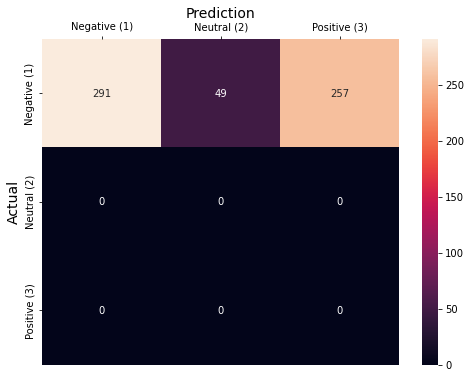

In [64]:
# y_pred = gru_model2.predict(X_test)
# y_pred=np.argmax(y_pred, axis=1)
# confusion_matrix(y_test, y_pred)
y = df_test['sentiment'].map({'negative': 0})
y_real = y.values
acc = accuracy_score(y_real, y_pred_test)
print('Model Accuracy on Test Data:', acc)

fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(confusion_matrix(y_true = y_real, y_pred = y_pred_test), fmt = 'g', annot = True)
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('Prediction', fontsize = 14)
ax.set_xticklabels(['Negative (1)', 'Neutral (2)', 'Positive (3)'])
ax.set_ylabel('Actual', fontsize = 14)
ax.set_yticklabels(['Negative (1)', 'Neutral (2)', 'Positive (3)'])
plt.show()